In [98]:
!pip install pygraphviz
!pip install pydot

You should consider upgrading via the '/home/fanpu/ml/bin/python -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/fanpu/ml/bin/python -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import pyarrow
import os
import numpy as np
import gensim
import nltk
import pickle
import ipdb
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from wordcloud import WordCloud
from tqdm import tqdm
from pprint import pprint
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer




In [3]:
pd.options.display.max_rows = 500
GEN_WORDCLOUD = False
DATA_DIR = "bz_desc_data/"
WORDCLOUD_DIR = "wordcloud/"
WORDCLOUD_TOPICS_DIR = "wordcloud_topics/"

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package stopwords to /home/fanpu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/fanpu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/fanpu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
def get_available_tickers():
    files = os.listdir(DATA_DIR)
    return [file.rstrip(".parquet") for file in files]

In [5]:
tickers = get_available_tickers()

In [6]:
stop_words = stopwords.words('english')
stop_words.extend(
    ['product', 'company', 'include', 'service', 'market', 'business', 'u', 'customer', 'financial', 'also', 'state', 'may', 'use', 'provide', 'new', 'year', 'result', 'cost', 'certain']

#     ['business', 'also', 'financial', 'market', 'u', 'may', 'company', 'include', 
#      'service', 'provide', 'customers', 'cost', 'operate', 'management', 'risk', 'report', 'information',
#      'result', 'approximately', 'require', 'use', 'us', 'relate', 'certain', 'operation', 'system', 'regulation', 'state', 'new',
#      'program', 'segment', 'base', 'sale', 'regulatory', 'million', 'year', 'time', 'subject', 'continue', 'change', 'well', 
#      'december', 'requirement', 'addition', 'term', 'could', 'increase', 'plan', 'revenue', 'believe', 'affect', 'product', 'customer'
#     ]
)
lemmatizer = WordNetLemmatizer()

def save_wordcloud(ticker, tokens):
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    # Generate a word cloud
    wordcloud.generate(",".join(tokens))
    # Visualize the word cloud
    wordcloud.to_file(f"{WORDCLOUD_DIR}/{ticker}.png")
    
def wordlist_for_ticker(ticker):
    """
    Returns:
        tokens, is_malformed
    """
    data = pd.read_parquet(f'{DATA_DIR}/{ticker}.parquet', engine='pyarrow')
    if len(data["word_list"]) == 0:
        return [], True
    tokens = np.concatenate(data["word_list"])
    if len(tokens) < 1000:
        return [], True
    def remove_numbers(tokens):
        return list(filter(lambda x : not x.isnumeric(), tokens))
    def remove_additional_stop_words(tokens):
        return list(filter(lambda x : not x in stop_words, tokens))
    def lemmatize(tokens):
        return [lemmatizer.lemmatize(token) for token in tokens]
    tokens = remove_numbers(tokens)
    tokens = lemmatize(tokens)
    tokens = remove_additional_stop_words(tokens)
    if GEN_WORDCLOUD:
        save_wordcloud(ticker, tokens)
    return tokens, False

In [7]:
clean_tickers = []
ticker_wordlist = {}
for ticker in tqdm(tickers):
    tokens, is_malformed = wordlist_for_ticker(ticker)
    if not is_malformed:
        clean_tickers.append(ticker)
        ticker_wordlist[ticker] = tokens
    else:
        # print(ticker, "is malformed, discarding")
        pass

100%|██| 726/726 [01:02<00:00, 11.68it/s]


In [8]:
len(tickers), len(clean_tickers)

(726, 536)

In [9]:
# Create Dictionary
id2word = corpora.Dictionary(ticker_wordlist.values())

# Term Document Frequency
corpus = [id2word.doc2bow(ticker_wordlist[ticker]) for ticker in clean_tickers]

In [10]:
# number of topics
num_topics = 30
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the top topics
pprint(lda_model.print_topics(num_topics=num_topics))
doc_lda = lda_model[corpus]

[(0,
  '0.004*"regulation" + 0.004*"risk" + 0.004*"sale" + 0.004*"management" + '
  '0.004*"investment" + 0.004*"operate" + 0.004*"operation" + 0.004*"subject" '
  '+ 0.003*"approximately" + 0.003*"information"'),
 (1,
  '0.005*"sale" + 0.004*"operation" + 0.004*"offer" + 0.004*"operate" + '
  '0.004*"continue" + 0.004*"technology" + 0.003*"system" + 0.003*"base" + '
  '0.003*"store" + 0.003*"well"'),
 (2,
  '0.004*"operation" + 0.004*"sale" + 0.004*"program" + 0.004*"information" + '
  '0.004*"system" + 0.003*"management" + 0.003*"regulation" + '
  '0.003*"investment" + 0.003*"report" + 0.003*"operate"'),
 (3,
  '0.004*"operate" + 0.004*"sale" + 0.004*"system" + 0.004*"operation" + '
  '0.004*"segment" + 0.003*"facility" + 0.003*"management" + 0.003*"offer" + '
  '0.003*"report" + 0.003*"program"'),
 (4,
  '0.005*"operation" + 0.005*"operate" + 0.004*"energy" + 0.004*"regulation" + '
  '0.004*"sale" + 0.004*"system" + 0.004*"management" + 0.004*"require" + '
  '0.004*"information" + 0

In [12]:
!pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 3.3 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Using cached scikit_learn-1.1.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.5 MB)
     |████████████████████████████████| 381 kB 22.9 MB/s            
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136882 sha256=2e067964f5bb27aac8cd46633181dfc5b39e75e932286b4661fc172060da2ee4
  Stored in directory: /home/fanpu/.cache/pip/wheels/e9/95/74/4766157910829d2fbc6b913850a62cfd15da77a199302cdf9c
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=8632080d990be2f1c78f1914c615da20f3d35966f57b67e00c61c812485beeaa
  Stored in directory: /home/fanpu/.cache/pip/wheels/c

In [13]:
import pyLDAvis
import pyLDAvis.gensim_models as gensim_models
import pickle 
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = gensim_models.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
LDAvis_prepared


/home/fanpu/ml/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/fanpu/ml/lib/python3.10/site-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  by='saliency', ascending=False).head(R).drop('saliency', 1)
/home/fanpu/ml/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  from imp import reload
/home/fanpu/ml/lib/python3.10/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alte

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
24     0.011415  0.005841       1        1  8.536769
10    -0.005663 -0.000072       2        1  6.169982
11     0.008599 -0.004769       3        1  5.765779
27    -0.003131  0.001734       4        1  5.653984
5     -0.001124 -0.005919       5        1  5.381176
3     -0.000276  0.004220       6        1  4.657643
26     0.004074  0.002958       7        1  4.315876
4     -0.001760 -0.004141       8        1  4.307377
16    -0.007122  0.001367       9        1  4.279387
1     -0.003175  0.005573      10        1  4.036450
7     -0.001261 -0.004711      11        1  3.557082
17    -0.002635 -0.000638      12        1  3.540436
12     0.001331 -0.004569      13        1  3.494739
9      0.004456 -0.000833      14        1  3.157196
0      0.005246 -0.001806      15        1  3.031499
28    -0.002663 -0.003915      16        1  2.678429
15    -0.004089 -0.000459      17        1  2.663373
8     -0.003707  0.003427      18        1  2.658375
23     0.001987 -0.000897      19        1  2.441475
6     -0.001937  0.000579      20        1  2.275869
20    -0.002125  0.001204      21        1  2.182232
13    -0.001205 -0.000126      22        1  2.147448
14    -0.001380 -0.001091      23        1  2.053100
22     0.000761  0.000941      24        1  2.004424
2     -0.001315  0.002172      25        1  1.896811
19     0.003640 -0.000057      26        1  1.880460
18    -0.000122  0.003339      27        1  1.846602
21     0.001044  0.000702      28        1  1.410850
25     0.001314 -0.000261      29        1  1.362828
29     0.000821  0.000208      30        1  0.612348, topic_info=            Term          Freq         Total Category  logprob  loglift
1521      system  58166.000000  58166.000000  Default  30.0000  30.0000
1291  regulation  56200.000000  56200.000000  Default  29.0000  29.0000
1364        sale  68166.000000  68166.000000  Default  28.0000  28.0000
1079   operation  69679.000000  69679.000000  Default  27.0000  27.0000
1349        risk  53025.000000  53025.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1219     program    248.932834  48302.379527  Topic30  -5.9833  -0.1724
1078     operate    263.594133  58558.764975  Topic30  -5.9261  -0.3078
1343     revenue    232.536515  40992.289031  Topic30  -6.0515  -0.0765
1538  technology    237.009785  45141.641177  Topic30  -6.0324  -0.1538
1293      relate    229.601192  42806.857707  Topic30  -6.0642  -0.1325

[2918 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
59281      1  0.090481    11ay
59281      2  0.090481    11ay
59281      3  0.090481    11ay
59281      4  0.090481    11ay
59281      5  0.090481    11ay
...      ...       ...     ...
13945      5  0.154652  ørsted
13945      8  0.077326  ørsted
13945      9  0.077326  ørsted
13945     11  0.077326  ørsted
13945     12  0.077326  ørsted

[31421 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[25, 11, 12, 28, 6, 4, 27, 5, 17, 2, 8, 18, 13, 10, 1, 29, 16, 9, 24, 7, 21, 14, 15, 23, 3, 20, 19, 22, 26, 30])

In [14]:
len(corpus), len(clean_tickers)

(536, 536)

In [15]:
lda_model.show_topics(num_topics)

[(0,
  '0.004*"regulation" + 0.004*"risk" + 0.004*"sale" + 0.004*"management" + 0.004*"investment" + 0.004*"operate" + 0.004*"operation" + 0.004*"subject" + 0.003*"approximately" + 0.003*"information"'),
 (1,
  '0.005*"sale" + 0.004*"operation" + 0.004*"offer" + 0.004*"operate" + 0.004*"continue" + 0.004*"technology" + 0.003*"system" + 0.003*"base" + 0.003*"store" + 0.003*"well"'),
 (2,
  '0.004*"operation" + 0.004*"sale" + 0.004*"program" + 0.004*"information" + 0.004*"system" + 0.003*"management" + 0.003*"regulation" + 0.003*"investment" + 0.003*"report" + 0.003*"operate"'),
 (3,
  '0.004*"operate" + 0.004*"sale" + 0.004*"system" + 0.004*"operation" + 0.004*"segment" + 0.003*"facility" + 0.003*"management" + 0.003*"offer" + 0.003*"report" + 0.003*"program"'),
 (4,
  '0.005*"operation" + 0.005*"operate" + 0.004*"energy" + 0.004*"regulation" + 0.004*"sale" + 0.004*"system" + 0.004*"management" + 0.004*"require" + 0.004*"information" + 0.004*"increase"'),
 (5,
  '0.005*"system" + 0.005*

In [16]:
lda_model.show_topics(num_topics)[0][1]
lda_model.get_topic_terms(topicid=0)

[(1291, 0.0044217454),
 (1349, 0.0039728573),
 (1364, 0.0039485423),
 (945, 0.0038542962),
 (835, 0.0037976184),
 (1078, 0.0037699295),
 (1079, 0.003755098),
 (1499, 0.0036746692),
 (102, 0.0034805757),
 (783, 0.003471806)]

def visualize_topics(topic_id):
    topic_terms = lda_model.get_topic_terms(topicid=topic_id, topn=30)
    freq_dict = {}
    for word_id, freq in topic_terms:
        freq_dict[id2word[word_id]] = freq
        
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
    wordcloud.generate_from_frequencies(freq_dict)
    # Visualize the word cloud
    # wordcloud.to_image()
    wordcloud.to_file(f"{WORDCLOUD_TOPICS_DIR}/{topic_id}.png")
    
for topic_id in range(num_topics):
    visualize_topics(topic_id)

In [51]:
def topics_for_ticker(ticker, ticker_index):
    print(ticker)
    topics = doc_lda[ticker_index]
    # Sort by frequency
    topics = sorted(topics, key = lambda x : x[1], reverse=True)
    return topics
    
    
tickers_and_topics = {}
for index, ticker in enumerate(clean_tickers):
    print("Ticker", ticker)
    topics = topics_for_ticker(ticker, index)
    print("Topics", topics)
    tickers_and_topics[ticker] = topics

with open('tickers_and_topics.pkl', 'wb') as f:
    pickle.dump(tickers_and_topics, f)


    

Ticker ORCL
ORCL
Topics [(3, 0.77476865), (10, 0.11837193), (20, 0.089274116)]
Ticker DRI
DRI
Topics [(1, 0.448513), (17, 0.40647173), (2, 0.032791805), (19, 0.028622916), (3, 0.015734093), (16, 0.011842168)]
Ticker LRCX
LRCX
Topics [(10, 0.8011396), (20, 0.04332894), (27, 0.0407131), (16, 0.029683402), (29, 0.029335728), (21, 0.015005254), (8, 0.0145685645)]
Ticker EFX
EFX
Topics [(26, 0.22587009), (18, 0.124425836), (16, 0.10033837), (29, 0.069136634), (6, 0.051537044), (23, 0.047707494), (24, 0.04635578), (14, 0.042623714), (2, 0.029705528), (20, 0.029545603), (5, 0.026625253), (17, 0.021186551), (4, 0.020809913), (0, 0.02079027), (10, 0.020345654), (11, 0.018885143), (7, 0.018253785), (15, 0.018237935), (22, 0.017361792)]
Ticker JEF
JEF
Topics [(0, 0.36346626), (24, 0.3396876), (11, 0.17029475), (19, 0.05448191), (7, 0.019978805), (9, 0.010368714)]
Ticker FRT
FRT
Topics [(11, 0.4167043), (0, 0.2565821), (19, 0.11908569), (7, 0.049572133), (23, 0.027441487), (26, 0.026241146), (9, 0

Topics [(9, 0.29591042), (26, 0.29463232), (0, 0.18840629), (24, 0.10499694), (25, 0.06048917), (11, 0.014862363), (14, 0.01092172)]
Ticker TGT
TGT
Topics [(17, 0.17584878), (1, 0.11547183), (27, 0.11046558), (14, 0.081422865), (5, 0.07229576), (23, 0.053233713), (11, 0.037596703), (7, 0.037019584), (26, 0.031123113), (12, 0.02691816), (19, 0.025245711), (22, 0.025139699), (0, 0.022390643), (3, 0.022151895), (4, 0.021380682), (13, 0.021160884), (16, 0.019708527), (18, 0.017651353), (6, 0.014752347), (15, 0.012731763), (24, 0.010174505)]
Ticker ARNC
ARNC
Topics [(27, 0.48475453), (7, 0.11791311), (23, 0.1111092), (10, 0.05016797), (26, 0.042786215), (3, 0.042042907), (21, 0.029238272), (17, 0.022618845), (6, 0.021012371), (4, 0.01505715), (5, 0.013749927)]
Ticker DOV
DOV
Topics [(17, 0.1557278), (4, 0.15198106), (21, 0.13790895), (10, 0.10870486), (16, 0.071843475), (18, 0.051594898), (20, 0.050521348), (27, 0.03991134), (5, 0.037804652), (3, 0.037212964), (14, 0.0361136), (15, 0.030981

Topics [(27, 0.24529025), (16, 0.23676793), (13, 0.14187786), (14, 0.04965444), (1, 0.047675796), (10, 0.0438685), (6, 0.024078356), (15, 0.023029508), (19, 0.022751749), (29, 0.020724187), (21, 0.020710403), (3, 0.018648606), (22, 0.015167947), (7, 0.012512157), (23, 0.012244671), (18, 0.01150096), (26, 0.010808635)]
Ticker MU
MU
Topics [(10, 0.5381081), (16, 0.21355085), (27, 0.10828386), (20, 0.057992976), (1, 0.028967079), (8, 0.012102853), (22, 0.010409735)]
Ticker FLIR
FLIR
Topics [(20, 0.64013076), (3, 0.12739058), (16, 0.09468519), (10, 0.080710374)]
Ticker COST
COST
Topics [(12, 0.14474905), (1, 0.094139114), (14, 0.091744475), (23, 0.06382776), (18, 0.05918611), (4, 0.057592873), (26, 0.04791467), (17, 0.04761787), (11, 0.045076698), (7, 0.04186165), (5, 0.037253134), (9, 0.032751378), (16, 0.025879355), (22, 0.025624549), (0, 0.02480105), (25, 0.023521487), (27, 0.02165191), (20, 0.016862916), (13, 0.014559829), (19, 0.014451994), (6, 0.013351733), (3, 0.011288347)]
Ticker T

Topics [(27, 0.826048), (25, 0.053694412), (28, 0.02704321), (22, 0.025539223), (8, 0.015536262), (2, 0.013599683), (15, 0.011603929)]
Ticker ETFC
ETFC
Topics [(11, 0.62536156), (24, 0.20632397), (0, 0.11170978), (23, 0.0106687)]
Ticker TPR
TPR
Topics [(1, 0.849253), (3, 0.03921776), (15, 0.03618668), (27, 0.020934388), (17, 0.015439101), (16, 0.015301545)]
Ticker AJG
AJG
Topics [(9, 0.45094788), (14, 0.093102865), (0, 0.07766666), (26, 0.07250635), (23, 0.051014848), (18, 0.045983862), (17, 0.033582453), (6, 0.027516998), (24, 0.025115166), (25, 0.011979174), (11, 0.0112204375), (15, 0.010355477)]
Ticker PEP
PEP
Topics [(7, 0.59114176), (4, 0.3015073), (19, 0.036703918), (14, 0.02115474), (25, 0.020442603), (22, 0.013430866)]
Ticker ARE
ARE
Topics [(0, 0.8029723), (11, 0.060874306), (19, 0.04191158), (14, 0.026293514), (22, 0.01337587), (7, 0.0109693995)]
Ticker ADS
ADS
Topics [(24, 0.4927984), (26, 0.059070986), (16, 0.058483645), (2, 0.05098349), (13, 0.047126945), (0, 0.03951433), 

Topics [(14, 0.7496759), (3, 0.06151816), (15, 0.053613137), (19, 0.033635102), (27, 0.026323609), (23, 0.022911128), (1, 0.020796608), (4, 0.0145420525)]
Ticker TRIP
TRIP
Topics [(1, 0.53615004), (3, 0.17109561), (6, 0.075771675), (24, 0.036956094), (26, 0.030832866), (17, 0.023464274), (16, 0.020541573), (19, 0.014312768), (10, 0.014223776), (2, 0.014128428), (18, 0.0140079195), (0, 0.012683876), (23, 0.011896549)]
Ticker NOV
NOV
Topics [(18, 0.83544284), (12, 0.101083465), (4, 0.020832235)]
Ticker TXN
TXN
Topics [(10, 0.5190891), (20, 0.14779449), (27, 0.097599074), (16, 0.059076354), (22, 0.059072323), (8, 0.03748452), (18, 0.020348664), (1, 0.018994195)]
Ticker HWM
HWM
Topics [(23, 0.74338555), (7, 0.1430377), (27, 0.04145448), (5, 0.01762769), (10, 0.011758574), (17, 0.011669986)]
Ticker DIS
DIS
Topics [(3, 0.74627703), (24, 0.1182305), (23, 0.093254685), (18, 0.010458599)]
Ticker EOG
EOG
Topics [(11, 0.58690715), (5, 0.33402812), (12, 0.039941855), (4, 0.019041797)]
Ticker J
J
T

Topics [(3, 0.20796213), (26, 0.14890853), (10, 0.1470502), (16, 0.10449382), (14, 0.0775018), (15, 0.05022581), (20, 0.04122021), (18, 0.039813347), (21, 0.031114668), (1, 0.029377906), (6, 0.023937939), (24, 0.021508107), (17, 0.01672903), (5, 0.0152452625), (22, 0.015130992)]
Ticker CINF
CINF
Topics [(0, 0.46327364), (14, 0.15428507), (9, 0.078090586), (11, 0.061982065), (26, 0.029507255), (24, 0.02757145), (16, 0.025232635), (6, 0.022014454), (25, 0.020903546), (5, 0.020789916), (18, 0.0154348975), (17, 0.015035044), (28, 0.011352115)]
Ticker WDC
WDC
Topics [(10, 0.30030537), (3, 0.20489007), (16, 0.14133856), (1, 0.11811396), (17, 0.05123934), (6, 0.040769894), (27, 0.024379015), (18, 0.016243488), (20, 0.014408531), (22, 0.013457849), (14, 0.012670555), (15, 0.012089589), (8, 0.011974041)]
Ticker MMI
MMI
Topics [(1, 0.47222072), (0, 0.2166799), (26, 0.071118526), (23, 0.031234888), (14, 0.030389234), (24, 0.025459902), (9, 0.019123077), (3, 0.016092896), (22, 0.015975123), (6, 0.

Topics [(5, 0.22892596), (4, 0.15820856), (16, 0.07253971), (15, 0.06405199), (10, 0.063455895), (27, 0.046080954), (14, 0.045174703), (3, 0.035305824), (18, 0.033741705), (6, 0.030598477), (7, 0.02350173), (17, 0.020464847), (8, 0.018707046), (21, 0.018338066), (20, 0.017783603), (23, 0.017779315), (2, 0.013409077), (22, 0.01252688), (1, 0.011489043)]
Ticker GWW
GWW
Topics [(23, 0.45258716), (27, 0.0964682), (14, 0.089038834), (16, 0.07139868), (0, 0.06534527), (15, 0.052980278), (29, 0.051193286), (17, 0.03524728), (1, 0.017487848), (3, 0.013678069), (7, 0.013556169), (10, 0.01166452)]
Ticker SNPS
SNPS
Topics [(10, 0.8329919), (16, 0.056010824), (20, 0.040606845), (15, 0.025057396), (3, 0.017498761)]
Ticker GHC
GHC
Topics [(23, 0.5068482), (3, 0.31111193), (12, 0.041771848), (26, 0.032213602), (22, 0.022943057), (9, 0.020094039)]
Ticker OMC
OMC
Topics [(14, 0.48416266), (3, 0.09339187), (1, 0.0922215), (23, 0.055983815), (16, 0.040252686), (22, 0.02879899), (6, 0.028126126), (13, 0.0

In [24]:
!pip install networkx

     |████████████████████████████████| 2.0 MB 3.4 MB/s            
You should consider upgrading via the '/home/fanpu/ml/bin/python -m pip install --upgrade pip' command.


In [131]:
usable_tickers = ['CAH', 'HBAN', 'EMN', 'ETN', 'VRSK', 'AWK', 'ROP', 'JNPR', 'CSX', 'LUV', 'WBA', 'JCI', 'TTWO', 'PSA', 'CMA', 'AAP', 'STZ', 'STX', 'ADP', 'PG', 'AMD', 'NEE', 'TGT', 'LDOS', 'UNH', 'MCO', 'VTRS', 'BK', 'MAA', 'TSCO', 'PFG', 'CVX', 'LUMN', 'RJF', 'LNT', 'EXR', 'DE', 'CF', 'MAS', 'LOW', 'GPC', 'ITW', 'MCK', 'EBAY', 'AON', 'BKR', 'TXT', 'BDX', 'T', 'TDY', 'JBHT', 'PPG', 'AMGN', 'SWK', 'J', 'CPB', 'MA', 'LRCX', 'DGX', 'PWR', 'SYY', 'HSIC', 'HON', 'NKE', 'AMZN', 'V', 'NTRS', 'CCI', 'CE', 'FDX', 'USB', 'XOM', 'MSFT', 'WMB', 'DPZ', 'FMC', 'BEN', 'TYL', 'UHS', 'CAT', 'KO', 'FAST', 'DXCM', 'AIZ', 'WM', 'LIN', 'HIG', 'MNST', 'A', 'SNPS', 'AMP', 'WDC', 'EQIX', 'SRE', 'INTU', 'XEL', 'SBUX', 'EMR', 'GL', 'REGN', 'VNO', 'L', 'GOOGL', 'CRL', 'RL', 'ADSK', 'ADM', 'ALB', 'MHK', 'CHRW', 'ALL', 'ESS', 'F', 'HST', 'CVS', 'PEP', 'CB', 'IT', 'SJM', 'WEC', 'PPL', 'EA', 'BMY', 'INCY', 'CINF', 'CL', 'NVDA', 'OKE', 'PKG', 'ORCL', 'MPWR', 'PNR', 'DVA', 'ANSS', 'TMO', 'PM', 'FRT', 'RF', 'AVY', 'ZION', 'HUM', 'COST', 'EQR', 'EOG', 'JNJ', 'GS', 'BLK', 'COF', 'PAYX', 'DLTR', 'TER', 'AVB', 'MDT', 'UNP', 'GLW', 'LLY', 'ACN', 'NLOK', 'MMM', 'GOOG', 'GPN', 'CPRT', 'TFX', 'INTC', 'DD', 'UAL', 'VMC', 'KR', 'TT', 'AFL', 'AKAM', 'WYNN', 'MCHP', 'PNW', 'BAC', 'GE', 'IFF', 'PKI', 'ARE', 'O', 'TEL', 'AEE', 'ORLY', 'BWA', 'MMC', 'PEAK', 'SNA', 'REG', 'ATVI', 'YUM', 'MTCH', 'TECH', 'ISRG', 'CRM', 'AJG', 'APH', 'TFC', 'SPGI', 'STE', 'DAL', 'CMS', 'JPM', 'ROST', 'DVN', 'MAR', 'MDLZ', 'SWKS', 'DRI', 'FIS', 'GRMN', 'EW', 'HD', 'HSY', 'ROK', 'ABC', 'MET', 'SO', 'MSI', 'DIS', 'RMD', 'URI', 'CI', 'TMUS', 'ECL', 'ES', 'LVS', 'PCG', 'TRV', 'IDXX', 'DG', 'PTC', 'BA', 'ABT', 'CNC', 'MTB', 'EFX', 'BBWI', 'VZ', 'DFS', 'NDAQ', 'BBY', 'COO', 'AMAT', 'EQT', 'WAB', 'MKTX', 'RE', 'MRK', 'AZO', 'SIVB', 'NUE', 'EVRG', 'HAS', 'TAP', 'PXD', 'LNC', 'IEX', 'NRG', 'JKHY', 'NSC', 'DUK', 'AME', 'HPQ', 'QCOM', 'UPS', 'LEN', 'RHI', 'BKNG', 'BAX', 'RSG', 'ZBH', 'HOLX', 'VRTX', 'MLM', 'CMI', 'AIG', 'RTX', 'SLB', 'DOV', 'IVZ', 'IRM', 'WST', 'TJX', 'CDNS', 'HES', 'VFC', 'CMCSA', 'CTAS', 'KMX', 'CBRE', 'MRO', 'NVR', 'ED', 'APD', 'AAPL', 'TRMB', 'GWW', 'WAT', 'BSX', 'MKC', 'POOL', 'MU', 'EL', 'SCHW', 'CNP', 'FE', 'NOC', 'SEE', 'HRL', 'NFLX', 'ZBRA', 'DXC', 'MGM', 'MTD', 'TPR', 'NTAP', 'FISV', 'D', 'DHI', 'FFIV', 'VTR', 'ULTA', 'WFC', 'STT', 'CTSH', 'EIX', 'IPG', 'TROW', 'ADI', 'GILD', 'AEP', 'MSCI', 'XRAY', 'UDR', 'OMC', 'BIO', 'MO', 'GIS', 'KIM', 'CMG', 'BIIB']

tickers = np.random.choice(usable_tickers, size=100)

In [132]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()

In [145]:
adj_mat = {}
num_top_topics = 2
num_other_top_topics = 1
min_relevance_thres = 0.6

for ticker in tickers:
    adj_mat[ticker] = []
    rel_topics = []
    relevance_cum_score = 0
    for topic, relevance in tickers_and_topics[ticker]:
        relevance_cum_score += relevance
        rel_topics.append(topic)
        if relevance_cum_score > min_relevance_thres:
            break
    #ticker_topics = set(list(map(lambda x : x[0], tickers_and_topics[ticker]))[:num_top_topics])
    ticker_topics = set(rel_topics)
    
    for other_ticker in tickers:
        if ticker == other_ticker:
            continue

        other_ticker_topics = set(list(map(lambda x : x[0], tickers_and_topics[other_ticker]))[:num_other_top_topics])
        if len(ticker_topics.intersection(other_ticker_topics)) != 0:
            adj_mat[ticker].append(other_ticker)

In [146]:
for ticker in adj_mat.keys():
    for nbor in adj_mat[ticker]:
        G.add_edges_from([(ticker, nbor)])

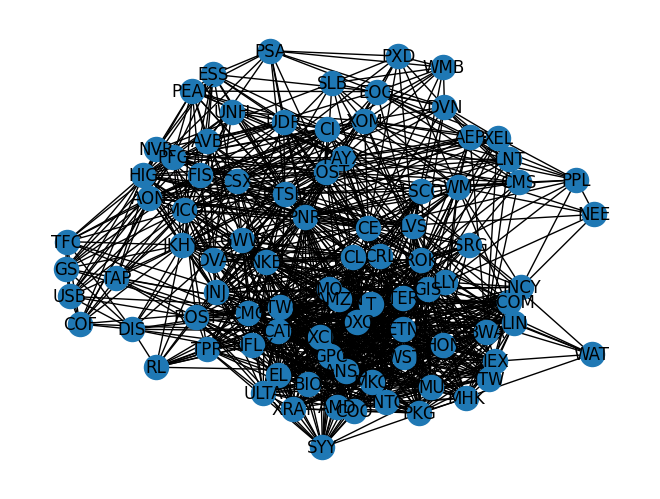

In [147]:

from networkx.drawing.nx_pydot import write_dot
pos = nx.nx_agraph.graphviz_layout(G)
nx.draw(G, with_labels=True, pos=pos)
write_dot(G, 'file.dot')


In [159]:
adj_mat_final = np.array(nx.adjacency_matrix(G).todense())

/tmp/ipykernel_166854/2006931282.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  [*np.array(nx.adjacency_matrix(G).todense())]
/home/fanpu/ml/lib/python3.10/site-packages/networkx/linalg/graphmatrix.py:173: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  return nx.to_scipy_sparse_matrix(G, nodelist=nodelist, dtype=dtype, weight=weight)


[array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]),
 array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
 array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0]),
 array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 